<a href="https://colab.research.google.com/github/avaniishh123/COE-Internship-DL-Project/blob/main/Copy_of_COE_DL_Project_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import files

files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"cavaniishh","key":"ac611b91f1eda13603bc820ac9074701"}'}

In [12]:
!mkdir -p ~/.kaggle
!mv /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [16]:
# Create a clean folder for raw datasets
!mkdir -p /content/polyp_raw


In [17]:
!kaggle datasets download -d debeshjha1/kvasirseg -p /content/polyp_raw --unzip
!kaggle datasets download -d balraj98/cvcclinicdb -p /content/polyp_raw --unzip
!kaggle datasets download -d nguyenvoquocduong/etis-laribpolypdb -p /content/polyp_raw --unzip

import os

print("Contents of /content/polyp_raw:")
for item in os.listdir("/content/polyp_raw"):
    print(" -", item)


Dataset URL: https://www.kaggle.com/datasets/debeshjha1/kvasirseg
License(s): copyright-authors
 87% 126M/144M [00:00<00:00, 1.32GB/s]
100% 144M/144M [00:00<00:00, 1.29GB/s]
Dataset URL: https://www.kaggle.com/datasets/balraj98/cvcclinicdb
License(s): other
 91% 119M/131M [00:00<00:00, 1.21GB/s]
100% 131M/131M [00:00<00:00, 865MB/s] 
Dataset URL: https://www.kaggle.com/datasets/nguyenvoquocduong/etis-laribpolypdb
License(s): unknown
 83% 147M/177M [00:00<00:00, 1.54GB/s]
100% 177M/177M [00:00<00:00, 1.26GB/s]
Contents of /content/polyp_raw:
 - val.txt
 - class_dict.csv
 - metadata.csv
 - images
 - train.txt
 - README.md
 - masks
 - TIF
 - Kvasir-SEG
 - PNG


In [18]:
import glob

imgs = (
    glob.glob("/content/polyp_raw/**/*.png", recursive=True) +
    glob.glob("/content/polyp_raw/**/*.jpg", recursive=True)
)

print("Total images found:", len(imgs))
print("Sample images:", imgs[:10])


Total images found: 4616
Sample images: ['/content/polyp_raw/images/158.png', '/content/polyp_raw/images/126.png', '/content/polyp_raw/images/30.png', '/content/polyp_raw/images/104.png', '/content/polyp_raw/images/33.png', '/content/polyp_raw/images/101.png', '/content/polyp_raw/images/147.png', '/content/polyp_raw/images/27.png', '/content/polyp_raw/images/49.png', '/content/polyp_raw/images/25.png']


In [24]:
import glob, os

IMG_EXTS = (".png",".jpg",".jpeg",".bmp",".tif",".tiff")

def count_imgs(d):
    return len([f for f in glob.glob(os.path.join(d, "*")) if os.path.isfile(f) and f.lower().endswith(IMG_EXTS)])

dirs = sorted(set(os.path.dirname(p) for p in glob.glob("/content/etis_tmp/extracted/**/*", recursive=True) if os.path.isfile(p)))

scored = []
for d in dirs:
    dl = d.lower()
    if any(x in dl for x in ["mask", "ground", "truth", "masks"]):
        continue
    n = count_imgs(d)
    if n > 0:
        scored.append((n, d))

scored.sort(reverse=True)
print("Top candidate dirs by image count:")
for n, d in scored[:20]:
    print(n, d)


Top candidate dirs by image count:
196 /content/etis_tmp/extracted/images


In [25]:
import os, glob, shutil

TGT_IMG_DIR = "/content/polyp_data/unified_final/target/images"
shutil.rmtree(TGT_IMG_DIR, ignore_errors=True)
os.makedirs(TGT_IMG_DIR, exist_ok=True)

IMG_EXTS = (".png",".jpg",".jpeg",".bmp",".tif",".tiff")

def list_imgs(d):
    return sorted([f for f in glob.glob(os.path.join(d, "*")) if os.path.isfile(f) and f.lower().endswith(IMG_EXTS)])

# auto-pick best image dir under extracted
candidate_dirs = sorted(set(os.path.dirname(p) for p in glob.glob("/content/etis_tmp/extracted/**/*", recursive=True) if os.path.isfile(p)))
candidate_dirs = [d for d in candidate_dirs if not any(x in d.lower() for x in ["mask","ground","truth","masks"])]
candidate_dirs = sorted(candidate_dirs, key=lambda d: len(list_imgs(d)), reverse=True)

ETIS_IMG_DIR = candidate_dirs[0]
imgs = list_imgs(ETIS_IMG_DIR)

for im in imgs:
    bid = os.path.splitext(os.path.basename(im))[0]
    ext = os.path.splitext(im)[1].lower()
    shutil.copy2(im, os.path.join(TGT_IMG_DIR, f"etis__{bid}{ext}"))

print("✅ Target fixed")
print("ETIS_IMG_DIR:", ETIS_IMG_DIR)
print("TGT images:", len(os.listdir(TGT_IMG_DIR)))
print("Sample:", os.listdir(TGT_IMG_DIR)[:10])


✅ Target fixed
ETIS_IMG_DIR: /content/etis_tmp/extracted/images
TGT images: 196
Sample: ['etis__31.png', 'etis__69.png', 'etis__184.png', 'etis__163.png', 'etis__16.png', 'etis__107.png', 'etis__60.png', 'etis__183.png', 'etis__171.png', 'etis__162.png']


In [27]:
!mkdir -p /content/polyp_raw/ETIS/images
!cp /content/etis_tmp/extracted/images/* /content/polyp_raw/ETIS/images/


In [28]:
import os, glob, shutil

RAW = "/content/polyp_raw"
UNIFIED = "/content/polyp_data/unified_final"

SRC_IMG_DIR  = os.path.join(UNIFIED, "source/images")
SRC_MASK_DIR = os.path.join(UNIFIED, "source/masks")
TGT_IMG_DIR  = os.path.join(UNIFIED, "target/images")

os.makedirs(SRC_IMG_DIR, exist_ok=True)
os.makedirs(SRC_MASK_DIR, exist_ok=True)
os.makedirs(TGT_IMG_DIR, exist_ok=True)

IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")

def list_files(root, exts=IMG_EXTS):
    files = glob.glob(os.path.join(root, "**", "*"), recursive=True)
    return sorted([f for f in files if os.path.isfile(f) and f.lower().endswith(exts)])

def pick_dir(candidates, must_contain_files=True):
    for d in candidates:
        if os.path.isdir(d):
            if (not must_contain_files) or len(list_files(d)) > 0:
                return d
    return None

def find_dirs_by_keywords(root, keywords):
    # returns directories whose full path contains any keyword (case-insensitive)
    dirs = sorted(set([os.path.dirname(p) for p in list_files(root)]))
    out = []
    for d in dirs:
        dl = d.lower()
        if any(k.lower() in dl for k in keywords):
            out.append(d)
    return sorted(list(dict.fromkeys(out)))

def copy_pairs(img_dir, mask_dir, prefix):
    imgs  = list_files(img_dir)
    masks = list_files(mask_dir)
    mask_map = {os.path.splitext(os.path.basename(m))[0]: m for m in masks}

    copied, missing = 0, 0
    for im in imgs:
        bid = os.path.splitext(os.path.basename(im))[0]
        mp = mask_map.get(bid, None)
        if mp is None:
            missing += 1
            continue

        im_ext = os.path.splitext(im)[1].lower()
        mp_ext = os.path.splitext(mp)[1].lower()

        out_im = os.path.join(SRC_IMG_DIR,  f"{prefix}__{bid}{im_ext}")
        out_m  = os.path.join(SRC_MASK_DIR, f"{prefix}__{bid}{mp_ext}")

        shutil.copy2(im, out_im)
        shutil.copy2(mp, out_m)
        copied += 1

    print(f"[{prefix}] img_dir={img_dir}")
    print(f"[{prefix}] mask_dir={mask_dir}")
    print(f"[{prefix}] copied pairs={copied} | missing_masks={missing}")
    return copied

def copy_images_only(img_dir, prefix):
    imgs = list_files(img_dir)
    copied = 0
    for im in imgs:
        bid = os.path.splitext(os.path.basename(im))[0]
        im_ext = os.path.splitext(im)[1].lower()
        out_im = os.path.join(TGT_IMG_DIR, f"{prefix}__{bid}{im_ext}")
        shutil.copy2(im, out_im)
        copied += 1
    print(f"[{prefix}] img_dir={img_dir}")
    print(f"[{prefix}] copied images={copied}")
    return copied

# ---------------------------
# 1) KVASIR-SEG (SOURCE)
# ---------------------------
# Prefer the flat structure you already have: /content/polyp_raw/images and /content/polyp_raw/masks
kvasir_img_dir = None
kvasir_mask_dir = None

if os.path.isdir(os.path.join(RAW, "images")) and os.path.isdir(os.path.join(RAW, "masks")):
    kvasir_img_dir = os.path.join(RAW, "images")
    kvasir_mask_dir = os.path.join(RAW, "masks")
else:
    # fallback to nested Kvasir-SEG folder
    k_img_candidates = [
        os.path.join(RAW, "Kvasir-SEG", "images"),
        os.path.join(RAW, "Kvasir-SEG", "Images"),
    ]
    k_msk_candidates = [
        os.path.join(RAW, "Kvasir-SEG", "masks"),
        os.path.join(RAW, "Kvasir-SEG", "Masks"),
    ]
    kvasir_img_dir = pick_dir(k_img_candidates)
    kvasir_mask_dir = pick_dir(k_msk_candidates)

if not (kvasir_img_dir and kvasir_mask_dir):
    raise FileNotFoundError("Could not locate Kvasir-SEG image/mask folders inside /content/polyp_raw.")

k_copied = copy_pairs(kvasir_img_dir, kvasir_mask_dir, "kvasir")
if k_copied == 0:
    raise RuntimeError("Kvasir copied 0 pairs. Folder structure is unexpected.")

# ---------------------------
# 2) CVC-ClinicDB (SOURCE)
# ---------------------------
# Common layouts:
#   .../PNG/Original + .../PNG/Ground Truth
#   .../PNG/Original + .../PNG/Ground_Truth
#   .../PNG/Original + .../PNG/GroundTruth
clinic_img_dir = None
clinic_mask_dir = None

# Find candidate dirs that include 'png' + 'original' and 'ground' in their names
png_dirs = find_dirs_by_keywords(RAW, ["png"])

orig_dirs  = [d for d in png_dirs if "original" in d.lower()]
gt_dirs    = [d for d in png_dirs if ("ground" in d.lower() and ("truth" in d.lower() or "gt" in d.lower()))]

# Prefer the deepest (most specific) directories
orig_dirs = sorted(orig_dirs, key=lambda x: len(x), reverse=True)
gt_dirs   = sorted(gt_dirs, key=lambda x: len(x), reverse=True)

clinic_img_dir  = orig_dirs[0] if orig_dirs else None
clinic_mask_dir = gt_dirs[0] if gt_dirs else None

if not (clinic_img_dir and clinic_mask_dir):
    # backup heuristic: search any dirs with many pngs and choose two best
    all_dirs = sorted(set([os.path.dirname(p) for p in list_files(RAW)]))
    scored = []
    for d in all_dirs:
        files = list_files(d, (".png",))
        if len(files) >= 50:
            scored.append((len(files), d))
    scored.sort(reverse=True)
    # try to pick two big dirs: one for images, one for masks
    # (this is fallback; usually not needed)
    if len(scored) >= 2:
        clinic_img_dir = scored[0][1]
        clinic_mask_dir = scored[1][1]

if not (clinic_img_dir and clinic_mask_dir):
    raise FileNotFoundError("Could not auto-locate CVC-ClinicDB image/mask folders. Print your /content/polyp_raw tree and I’ll tailor it.")

c_copied = copy_pairs(clinic_img_dir, clinic_mask_dir, "clinicdb")
print(f"[clinicdb] NOTE: if copied=0, we need to point to the correct ClinicDB folders.")

# ---------------------------
# ---------------------------
# 3) ETIS-Larib (TARGET ONLY)
# ---------------------------
# IMPORTANT: Do NOT auto-detect ETIS from RAW because RAW contains Kvasir/Clinic too
# We explicitly use the ETIS extraction location we verified (196 images).
ETIS_EXTRACTED_IMG_DIR = "/content/polyp_raw/ETIS/images"


if not os.path.isdir(ETIS_EXTRACTED_IMG_DIR) or len(list_files(ETIS_EXTRACTED_IMG_DIR)) == 0:
    raise FileNotFoundError(
        f"ETIS image dir not found / empty: {ETIS_EXTRACTED_IMG_DIR}. "
        "Re-run the ETIS unzip step to /content/etis_tmp/extracted."
    )

# Clean target folder before copying (prevents old wrong target staying there)
shutil.rmtree(TGT_IMG_DIR, ignore_errors=True)
os.makedirs(TGT_IMG_DIR, exist_ok=True)

e_copied = copy_images_only(ETIS_EXTRACTED_IMG_DIR, "etis")
print(f"[etis] copied images={e_copied} (should be ~196)")

# ---------------------------
# Final summary
# ---------------------------
print("\n===== UNIFIED SUMMARY =====")
print("SRC images:", len(os.listdir(SRC_IMG_DIR)))
print("SRC masks :", len(os.listdir(SRC_MASK_DIR)))
print("TGT images:", len(os.listdir(TGT_IMG_DIR)))
print("Unified root:", UNIFIED)


[kvasir] img_dir=/content/polyp_raw/images
[kvasir] mask_dir=/content/polyp_raw/masks
[kvasir] copied pairs=196 | missing_masks=0
[clinicdb] img_dir=/content/polyp_raw/PNG/Original
[clinicdb] mask_dir=/content/polyp_raw/PNG/Ground Truth
[clinicdb] copied pairs=612 | missing_masks=0
[clinicdb] NOTE: if copied=0, we need to point to the correct ClinicDB folders.
[etis] img_dir=/content/polyp_raw/ETIS/images
[etis] copied images=196
[etis] copied images=196 (should be ~196)

===== UNIFIED SUMMARY =====
SRC images: 808
SRC masks : 808
TGT images: 196
Unified root: /content/polyp_data/unified_final


In [1]:
import os
import glob
import random
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
import matplotlib.pyplot as plt


In [29]:
IMG_SIZE = 256
BATCH_SIZE = 8
SRC_IMG_DIR  = "/content/polyp_data/unified_final/source/images"
SRC_MASK_DIR = "/content/polyp_data/unified_final/source/masks"
TGT_IMG_DIR  = "/content/polyp_data/unified_final/target/images"
CHECKPOINT_DIR = "/content/checkpoints_adapt"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

EPOCHS = 30
LEARNING_RATE = 2e-4
SEED = 42
np.random.seed(SEED); tf.random.set_seed(SEED); random.seed(SEED)

# ✅ small upgrade: allow only valid image extensions
IMG_EXTS = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")

def read_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img.set_shape([None, None, 3])  # helps tf.data shape inference
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE], method=tf.image.ResizeMethod.BILINEAR)
    img = tf.cast(img, tf.float32) / 127.5 - 1.0  # [-1,1]
    return img

def read_mask(path):
    m = tf.io.read_file(path)
    m = tf.image.decode_image(m, channels=1, expand_animations=False)
    m.set_shape([None, None, 1])  # helps tf.data shape inference

    # IMPORTANT: nearest neighbor for masks
    m = tf.image.resize(m, [IMG_SIZE, IMG_SIZE], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # HARD binarize (better Dice + stable boundaries)
    m = tf.cast(m, tf.float32)
    m = tf.where(m > 127.0, 1.0, 0.0)
    return m

def random_flip_rotate(image, mask=None):
    if tf.random.uniform([]) > 0.5:
        image = tf.image.flip_left_right(image)
        if mask is not None:
            mask = tf.image.flip_left_right(mask)

    if tf.random.uniform([]) > 0.5:
        image = tf.image.flip_up_down(image)
        if mask is not None:
            mask = tf.image.flip_up_down(mask)

    k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    if mask is not None:
        mask = tf.image.rot90(mask, k)

    return (image, mask) if mask is not None else image

def make_source_dataset(img_dir, mask_dir, batch_size=BATCH_SIZE, augment=True, repeat=True, use_cache=True):
    # ✅ upgrade #1: filter only image files
    img_paths = sorted([p for p in glob.glob(os.path.join(img_dir, "*"))
                        if p.lower().endswith(IMG_EXTS)])
    mask_paths = sorted([p for p in glob.glob(os.path.join(mask_dir, "*"))
                         if p.lower().endswith(IMG_EXTS)])

    # Build a fast lookup: base_id -> mask_path
    mask_map = {}
    for mp in mask_paths:
        mbase = os.path.splitext(os.path.basename(mp))[0]
        base_id = mbase.split("__")[-1]
        mask_map.setdefault(base_id, mp)

    pairs = []
    missing = 0
    for ip in img_paths:
        ibase = os.path.splitext(os.path.basename(ip))[0]
        base_id = ibase.split("__")[-1]
        mp = mask_map.get(base_id, None)
        if mp is None:
            missing += 1
            continue
        pairs.append((ip, mp))

    print(f"Source images: {len(img_paths)} | masks: {len(mask_paths)} | pairs: {len(pairs)} | missing_masks: {missing}")

    if len(pairs) == 0:
        raise ValueError("No (image, mask) pairs found. Check naming/prefix rules and directories.")

    img_t  = [p[0] for p in pairs]
    mask_t = [p[1] for p in pairs]

    ds = tf.data.Dataset.from_tensor_slices((img_t, mask_t))

    def _map(i, m):
        img  = read_image(i)
        mask = read_mask(m)
        if augment:
            img, mask = random_flip_rotate(img, mask)
        return img, mask

    ds = ds.shuffle(buffer_size=min(4096, len(pairs)), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(_map, num_parallel_calls=tf.data.AUTOTUNE)

    # ✅ upgrade #2: cache (optional)
    if use_cache:
        ds = ds.cache()

    if repeat:
        ds = ds.repeat()

    ds = ds.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    return ds

def make_target_dataset(img_dir, batch_size=BATCH_SIZE, augment=False, repeat=True, shuffle=True, use_cache=True):
    # ✅ upgrade #1: filter only valid image files + non-empty
    img_paths = sorted([
        p for p in glob.glob(os.path.join(img_dir, "*"))
        if os.path.getsize(p) > 0 and p.lower().endswith(IMG_EXTS)
    ])
    print("Target images:", len(img_paths))

    if len(img_paths) == 0:
        raise ValueError("No target images found. Check TGT_IMG_DIR.")

    ds = tf.data.Dataset.from_tensor_slices(img_paths)

    def _map(i):
        img = read_image(i)
        if augment:
            img = random_flip_rotate(img)  # returns image only
        return img

    if shuffle:
        ds = ds.shuffle(buffer_size=min(4096, len(img_paths)), seed=SEED, reshuffle_each_iteration=True)

    ds = ds.map(_map, num_parallel_calls=tf.data.AUTOTUNE)

    # ✅ upgrade #2: cache (optional)
    if use_cache:
        ds = ds.cache()

    if repeat:
        ds = ds.repeat()

    ds = ds.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    return ds

# build datasets
src_ds = make_source_dataset(SRC_IMG_DIR, SRC_MASK_DIR, BATCH_SIZE, augment=True, repeat=True, use_cache=True)
tgt_ds = make_target_dataset(TGT_IMG_DIR, BATCH_SIZE, augment=False, repeat=True, shuffle=True, use_cache=True)

# Quick sanity test (run once)
s_img, s_mask = next(iter(src_ds))
t_img = next(iter(tgt_ds))

print("SRC img:", s_img.shape, s_img.dtype, float(tf.reduce_min(s_img)), float(tf.reduce_max(s_img)))
print("SRC mask:", s_mask.shape, s_mask.dtype, float(tf.reduce_min(s_mask)), float(tf.reduce_max(s_mask)))
print("TGT img:", t_img.shape, t_img.dtype, float(tf.reduce_min(t_img)), float(tf.reduce_max(t_img)))


Source images: 808 | masks: 808 | pairs: 808 | missing_masks: 0
Target images: 196
SRC img: (8, 256, 256, 3) <dtype: 'float32'> -1.0 1.0
SRC mask: (8, 256, 256, 1) <dtype: 'float32'> 0.0 1.0
TGT img: (8, 256, 256, 3) <dtype: 'float32'> -1.0 1.0


In [30]:
# -------------------------
# Models
# -------------------------
def build_unet(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = layers.Input(shape=input_shape)

    def conv_block(x, filters):
        x = layers.Conv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        return x

    c1 = conv_block(inputs, 32);  p1 = layers.MaxPool2D()(c1)
    c2 = conv_block(p1, 64);      p2 = layers.MaxPool2D()(c2)
    c3 = conv_block(p2, 128);     p3 = layers.MaxPool2D()(c3)
    c4 = conv_block(p3, 256);     p4 = layers.MaxPool2D()(c4)
    b  = conv_block(p4, 512)

    u1 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(b)
    u1 = layers.Concatenate()([u1, c4]); u1 = conv_block(u1, 256)

    u2 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(u1)
    u2 = layers.Concatenate()([u2, c3]); u2 = conv_block(u2, 128)

    u3 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(u2)
    u3 = layers.Concatenate()([u3, c2]); u3 = conv_block(u3, 64)

    u4 = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(u3)
    u4 = layers.Concatenate()([u4, c1]); u4 = conv_block(u4, 32)

    out = layers.Conv2D(1, 1, activation='sigmoid')(u4)
    return models.Model(inputs, out, name="UNet")


# PatchGAN discriminator that takes single-channel mask-like input
def build_discriminator(input_shape=(IMG_SIZE, IMG_SIZE, 1)):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 4, strides=2, padding='same')(inp);  x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(128, 4, strides=2, padding='same')(x);   x = layers.BatchNormalization()(x); x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(256, 4, strides=2, padding='same')(x);   x = layers.BatchNormalization()(x); x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(512, 4, strides=1, padding='same')(x);   x = layers.BatchNormalization()(x); x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(1, 4, strides=1, padding='same')(x)      # logits
    return models.Model(inp, x, name="PatchGAN")


generator = build_unet()
discriminator = build_discriminator()
generator.summary()
discriminator.summary()

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ re_lu[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ re_lu_3[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_4[0][0]  

 Total params: 7,771,873 (29.65 MB)

 Trainable params: 7,765,985 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

Model: "PatchGAN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 128, 128, 64)   │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 32, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 32, 32, 512)    │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 32, 32, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 32, 32, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,766,273 (10.55 MB)

 Trainable params: 2,764,481 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [33]:
# -------------------------
# Losses
# -------------------------
bce_logits = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    inter = tf.reduce_sum(y_true_f * y_pred_f)
    return 1.0 - (2.0 * inter + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def seg_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true, y_pred))

gen_opt  = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=0.5)
disc_opt = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=0.5)

# -------------------------
# ✅ Updated training step:
#   - real label smoothing for D: real = 0.9
#   - train D less often: only when global_step % d_update_every == 0
#   - always train G
#   - keeps: D uses stop_gradient preds; pseudo uses pos+neg; adv on target
# -------------------------
@tf.function
def train_step(
    src_images, src_masks, tgt_images,
    global_step,
    d_update_every=2,
    t_pos=0.9, t_neg=0.1,
    adv_weight=0.01, pseudo_weight=0.2
):
    with tf.GradientTape(persistent=True) as tape:
        # ---- Generator forward ----
        pred_src = generator(src_images, training=True)   # [B,H,W,1]
        pred_tgt = generator(tgt_images, training=True)   # [B,H,W,1]

        # ---- Discriminator forward (DETACH preds for D) ----
        d_real     = discriminator(src_masks, training=True)
        d_fake_src = discriminator(tf.stop_gradient(pred_src), training=True)
        d_fake_tgt = discriminator(tf.stop_gradient(pred_tgt), training=True)

        # ---- Supervised seg on source ----
        seg_l = seg_loss(src_masks, pred_src)

        # ---- Discriminator loss with REAL LABEL SMOOTHING ----
        real_labels = tf.ones_like(d_real) * 0.9
        d_loss_real = bce_logits(real_labels, d_real)
        d_loss_fake_src = bce_logits(tf.zeros_like(d_fake_src), d_fake_src)
        d_loss_fake_tgt = bce_logits(tf.zeros_like(d_fake_tgt), d_fake_tgt)
        disc_loss = (d_loss_real + d_loss_fake_src + d_loss_fake_tgt) / 3.0

        # ---- Generator adversarial loss on TARGET ----
        d_tgt_for_g = discriminator(pred_tgt, training=False)  # keeps D BN stable for G-loss
        gen_adv_tgt = bce_logits(tf.ones_like(d_tgt_for_g), d_tgt_for_g)

        # ---- Pseudo-label self-training on target: confident POS + NEG ----
        pos = pred_tgt > t_pos
        neg = pred_tgt < t_neg
        conf = tf.logical_or(pos, neg)

        conf_f = tf.cast(conf, tf.float32)
        high_conf_ratio = tf.reduce_mean(conf_f)

        pseudo = tf.where(pos, 1.0, 0.0)  # pos->1, neg->0, others unused

        flat_pred   = tf.reshape(pred_tgt, [-1])
        flat_pseudo = tf.reshape(pseudo, [-1])
        flat_conf   = tf.reshape(conf_f, [-1])

        sel_pred = tf.boolean_mask(flat_pred, flat_conf > 0)
        sel_lab  = tf.boolean_mask(flat_pseudo, flat_conf > 0)

        num_conf = tf.size(sel_pred)

        def _pseudo_loss():
            return tf.reduce_mean(tf.keras.losses.binary_crossentropy(sel_lab, sel_pred))

        pseudo_loss = tf.cond(num_conf > 0, _pseudo_loss, lambda: 0.0)

        # ---- Total generator loss ----
        gen_total = seg_l + adv_weight * gen_adv_tgt + pseudo_weight * pseudo_loss

    # ---- Always update Generator ----
    grads_g = tape.gradient(gen_total, generator.trainable_variables)
    gen_opt.apply_gradients(zip(grads_g, generator.trainable_variables))

    # ---- Update Discriminator only every d_update_every steps ----
    do_d_update = tf.equal(tf.math.floormod(global_step, d_update_every), 0)

    def _apply_d():
        grads_d = tape.gradient(disc_loss, discriminator.trainable_variables)
        disc_opt.apply_gradients(zip(grads_d, discriminator.trainable_variables))
        return disc_loss

    def _skip_d():
        return disc_loss  # report it anyway

    disc_loss_out = tf.cond(do_d_update, _apply_d, _skip_d)

    return {
        "gen_total": gen_total,
        "seg_l": seg_l,
        "gen_adv_tgt": gen_adv_tgt,
        "disc_loss": disc_loss_out,
        "pseudo_loss": pseudo_loss,
        "high_conf_ratio": high_conf_ratio
    }

# -------------------------
# Evaluation helper (unchanged)
# -------------------------
def compute_metrics_on_batch(y_true, y_pred):
    y_pred_bin = tf.cast(y_pred > 0.5, tf.float32)
    inter = tf.reduce_sum(y_true * y_pred_bin)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred_bin)
    dice = (2.0 * inter + 1e-6) / (union + 1e-6)

    iou = (inter + 1e-6) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred_bin) - inter + 1e-6)
    return dice.numpy(), iou.numpy()


In [32]:
steps_per_epoch = len(glob.glob(os.path.join(SRC_IMG_DIR, "*"))) // BATCH_SIZE


train_ds = tf.data.Dataset.zip((src_ds, tgt_ds))  # both already repeat=True

best_val_dice = -1.0
global_step = 0

for epoch in range(EPOCHS):
    print(f"\n=== Epoch {epoch+1}/{EPOCHS} ===")
    pbar = tqdm(train_ds.take(steps_per_epoch), total=steps_per_epoch)

    stats = {
        "gen_total": [], "seg_l": [], "gen_adv_tgt": [],
        "disc_loss": [], "pseudo_loss": [], "high_conf_ratio": []
    }

    for (src_imgs, src_masks), tgt_imgs in pbar:
        res = train_step(src_imgs, src_masks, tgt_imgs)  # uses defaults you set
        for k, v in res.items():
            stats[k].append(float(v.numpy()))
        global_step += 1

        pbar.set_description(
            f"g:{np.mean(stats['gen_total']):.4f} "
            f"s:{np.mean(stats['seg_l']):.4f} "
            f"d:{np.mean(stats['disc_loss']):.4f}"
        )

    print("Epoch summary:",
          f"Gen:{np.mean(stats['gen_total']):.4f}",
          f"Seg:{np.mean(stats['seg_l']):.4f}",
          f"AdvTgt:{np.mean(stats['gen_adv_tgt']):.4f}",
          f"Disc:{np.mean(stats['disc_loss']):.4f}",
          f"Pseudo:{np.mean(stats['pseudo_loss']):.4f}",
          f"Conf:{np.mean(stats['high_conf_ratio']):.4f}")

    # Save weights each epoch
    generator.save_weights(os.path.join(CHECKPOINT_DIR, f"generator_epoch_{epoch+1}.weights.h5"))
    discriminator.save_weights(os.path.join(CHECKPOINT_DIR, f"discriminator_epoch_{epoch+1}.weights.h5"))



=== Epoch 1/30 ===


g:1.3382 s:1.3182 d:0.1856: 100%|██████████| 101/101 [01:49<00:00,  1.08s/it]


Epoch summary: Gen:1.3382 Seg:1.3182 AdvTgt:0.9912 Disc:0.1856 Pseudo:0.0505 Conf:0.0426

=== Epoch 2/30 ===


g:1.1672 s:1.1299 d:0.0267: 100%|██████████| 101/101 [01:18<00:00,  1.29it/s]


Epoch summary: Gen:1.1672 Seg:1.1299 AdvTgt:2.9456 Disc:0.0267 Pseudo:0.0394 Conf:0.0793

=== Epoch 3/30 ===


g:1.1091 s:1.0583 d:0.0482: 100%|██████████| 101/101 [01:18<00:00,  1.29it/s]


Epoch summary: Gen:1.1091 Seg:1.0583 AdvTgt:4.0263 Disc:0.0482 Pseudo:0.0530 Conf:0.1497

=== Epoch 4/30 ===


g:1.0327 s:0.9843 d:0.0073: 100%|██████████| 101/101 [01:18<00:00,  1.29it/s]


Epoch summary: Gen:1.0327 Seg:0.9843 AdvTgt:3.4891 Disc:0.0073 Pseudo:0.0675 Conf:0.3593

=== Epoch 5/30 ===


g:1.0119 s:0.9214 d:0.1450: 100%|██████████| 101/101 [01:18<00:00,  1.29it/s]


Epoch summary: Gen:1.0119 Seg:0.9214 AdvTgt:7.8002 Disc:0.1450 Pseudo:0.0627 Conf:0.4818

=== Epoch 6/30 ===


g:0.9008 s:0.8581 d:0.0548: 100%|██████████| 101/101 [01:18<00:00,  1.29it/s]


Epoch summary: Gen:0.9008 Seg:0.8581 AdvTgt:3.1256 Disc:0.0548 Pseudo:0.0571 Conf:0.6202

=== Epoch 7/30 ===


g:0.8646 s:0.8056 d:0.0649: 100%|██████████| 101/101 [01:18<00:00,  1.29it/s]


Epoch summary: Gen:0.8646 Seg:0.8056 AdvTgt:4.9446 Disc:0.0649 Pseudo:0.0479 Conf:0.6702

=== Epoch 8/30 ===


g:0.8035 s:0.7642 d:0.0106: 100%|██████████| 101/101 [01:18<00:00,  1.29it/s]


Epoch summary: Gen:0.8035 Seg:0.7642 AdvTgt:3.0744 Disc:0.0106 Pseudo:0.0430 Conf:0.7420

=== Epoch 9/30 ===


g:0.7747 s:0.7277 d:0.0866: 100%|██████████| 101/101 [01:18<00:00,  1.29it/s]


Epoch summary: Gen:0.7747 Seg:0.7277 AdvTgt:3.9558 Disc:0.0866 Pseudo:0.0369 Conf:0.7857

=== Epoch 10/30 ===


g:0.7411 s:0.6963 d:0.0743: 100%|██████████| 101/101 [01:18<00:00,  1.29it/s]


Epoch summary: Gen:0.7411 Seg:0.6963 AdvTgt:3.8026 Disc:0.0743 Pseudo:0.0337 Conf:0.8433

=== Epoch 11/30 ===


g:0.6894 s:0.6497 d:0.0526: 100%|██████████| 101/101 [01:18<00:00,  1.29it/s]


Epoch summary: Gen:0.6894 Seg:0.6497 AdvTgt:3.4039 Disc:0.0526 Pseudo:0.0284 Conf:0.8760

=== Epoch 12/30 ===


g:0.6595 s:0.6251 d:0.0545: 100%|██████████| 101/101 [01:18<00:00,  1.29it/s]


Epoch summary: Gen:0.6595 Seg:0.6251 AdvTgt:2.9742 Disc:0.0545 Pseudo:0.0234 Conf:0.8721

=== Epoch 13/30 ===


g:0.6315 s:0.5993 d:0.0360: 100%|██████████| 101/101 [01:18<00:00,  1.29it/s]


Epoch summary: Gen:0.6315 Seg:0.5993 AdvTgt:2.8207 Disc:0.0360 Pseudo:0.0199 Conf:0.8834

=== Epoch 14/30 ===


g:0.6019 s:0.5612 d:0.0043: 100%|██████████| 101/101 [01:18<00:00,  1.29it/s]


Epoch summary: Gen:0.6019 Seg:0.5612 AdvTgt:3.7179 Disc:0.0043 Pseudo:0.0172 Conf:0.8802

=== Epoch 15/30 ===


g:0.5893 s:0.5441 d:0.0385: 100%|██████████| 101/101 [01:18<00:00,  1.29it/s]


Epoch summary: Gen:0.5893 Seg:0.5441 AdvTgt:4.2169 Disc:0.0385 Pseudo:0.0156 Conf:0.8800

=== Epoch 16/30 ===


g:0.5542 s:0.5190 d:0.0759: 100%|██████████| 101/101 [01:18<00:00,  1.29it/s]


Epoch summary: Gen:0.5542 Seg:0.5190 AdvTgt:3.2085 Disc:0.0759 Pseudo:0.0157 Conf:0.9011

=== Epoch 17/30 ===


g:0.5247 s:0.4958 d:0.0447: 100%|██████████| 101/101 [01:18<00:00,  1.29it/s]


Epoch summary: Gen:0.5247 Seg:0.4958 AdvTgt:2.5828 Disc:0.0447 Pseudo:0.0151 Conf:0.9015

=== Epoch 18/30 ===


g:0.5125 s:0.4790 d:0.0405: 100%|██████████| 101/101 [01:18<00:00,  1.29it/s]


Epoch summary: Gen:0.5125 Seg:0.4790 AdvTgt:3.0894 Disc:0.0405 Pseudo:0.0130 Conf:0.8956

=== Epoch 19/30 ===


g:0.4932 s:0.4648 d:0.0448: 100%|██████████| 101/101 [01:18<00:00,  1.29it/s]


Epoch summary: Gen:0.4932 Seg:0.4648 AdvTgt:2.5912 Disc:0.0448 Pseudo:0.0123 Conf:0.9115

=== Epoch 20/30 ===


g:0.4716 s:0.4384 d:0.0576: 100%|██████████| 101/101 [01:18<00:00,  1.29it/s]


Epoch summary: Gen:0.4716 Seg:0.4384 AdvTgt:3.0826 Disc:0.0576 Pseudo:0.0121 Conf:0.8918

=== Epoch 21/30 ===


g:0.4697 s:0.4288 d:0.1529: 100%|██████████| 101/101 [01:18<00:00,  1.29it/s]


Epoch summary: Gen:0.4697 Seg:0.4288 AdvTgt:3.8792 Disc:0.1529 Pseudo:0.0102 Conf:0.9211

=== Epoch 22/30 ===


g:0.4427 s:0.4155 d:0.0969: 100%|██████████| 101/101 [01:18<00:00,  1.29it/s]


Epoch summary: Gen:0.4427 Seg:0.4155 AdvTgt:2.5357 Disc:0.0969 Pseudo:0.0096 Conf:0.9398

=== Epoch 23/30 ===


g:0.4131 s:0.3812 d:0.0594: 100%|██████████| 101/101 [01:18<00:00,  1.29it/s]


Epoch summary: Gen:0.4131 Seg:0.3812 AdvTgt:2.9870 Disc:0.0594 Pseudo:0.0099 Conf:0.9264

=== Epoch 24/30 ===


g:0.4009 s:0.3689 d:0.0541: 100%|██████████| 101/101 [01:18<00:00,  1.29it/s]


Epoch summary: Gen:0.4009 Seg:0.3689 AdvTgt:3.0110 Disc:0.0541 Pseudo:0.0093 Conf:0.9229

=== Epoch 25/30 ===


g:0.4000 s:0.3634 d:0.0354: 100%|██████████| 101/101 [01:18<00:00,  1.29it/s]


Epoch summary: Gen:0.4000 Seg:0.3634 AdvTgt:3.5151 Disc:0.0354 Pseudo:0.0076 Conf:0.9276

=== Epoch 26/30 ===


g:0.3780 s:0.3436 d:0.0310: 100%|██████████| 101/101 [01:18<00:00,  1.29it/s]


Epoch summary: Gen:0.3780 Seg:0.3436 AdvTgt:3.3031 Disc:0.0310 Pseudo:0.0071 Conf:0.9264

=== Epoch 27/30 ===


g:0.3824 s:0.3350 d:0.0045: 100%|██████████| 101/101 [01:18<00:00,  1.29it/s]


Epoch summary: Gen:0.3824 Seg:0.3350 AdvTgt:4.6034 Disc:0.0045 Pseudo:0.0066 Conf:0.9288

=== Epoch 28/30 ===


g:0.3932 s:0.3364 d:0.0987: 100%|██████████| 101/101 [01:18<00:00,  1.29it/s]


Epoch summary: Gen:0.3932 Seg:0.3364 AdvTgt:5.5535 Disc:0.0987 Pseudo:0.0062 Conf:0.9344

=== Epoch 29/30 ===


g:0.3500 s:0.3173 d:0.1471: 100%|██████████| 101/101 [01:21<00:00,  1.23it/s]


Epoch summary: Gen:0.3500 Seg:0.3173 AdvTgt:3.1529 Disc:0.1471 Pseudo:0.0060 Conf:0.9519

=== Epoch 30/30 ===


g:0.3351 s:0.3071 d:0.1293: 100%|██████████| 101/101 [01:18<00:00,  1.29it/s]


Epoch summary: Gen:0.3351 Seg:0.3071 AdvTgt:2.6696 Disc:0.1293 Pseudo:0.0065 Conf:0.9415


In [42]:
BEST_EPOCH = 30
generator.load_weights(f"{CHECKPOINT_DIR}/generator_epoch_{BEST_EPOCH}.weights.h5")
generator.trainable = False
print("Model loaded for inference")


Model loaded for inference


In [43]:
import os, glob, cv2
import numpy as np
from tqdm import tqdm

ETIS_DIR = "/content/polyp_data/unified_final/target/images"
OUT_DIR  = f"/content/etis_results_epoch_{BEST_EPOCH}"
PRED_DIR = os.path.join(OUT_DIR, "pred_masks")
OVR_DIR  = os.path.join(OUT_DIR, "overlays")
os.makedirs(PRED_DIR, exist_ok=True)
os.makedirs(OVR_DIR, exist_ok=True)

paths = sorted([p for p in glob.glob(os.path.join(ETIS_DIR, "*"))
                if p.lower().endswith((".png",".jpg",".jpeg",".bmp",".tif",".tiff"))])

def load_img_rgb_and_norm(path, size=256):
    bgr = cv2.imread(path)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    rgb = cv2.resize(rgb, (size, size), interpolation=cv2.INTER_LINEAR)
    x = (rgb.astype(np.float32) / 127.5) - 1.0
    return rgb, x

def overlay(rgb, mask01, alpha=0.45):
    color = np.zeros_like(rgb)
    color[:, :, 1] = 255  # green
    m = mask01[..., None].astype(np.float32)
    out = rgb.astype(np.float32) * (1 - alpha*m) + color.astype(np.float32) * (alpha*m)
    return out.astype(np.uint8)

for p in tqdm(paths):
    rgb, x = load_img_rgb_and_norm(p, IMG_SIZE)
    pred = generator(np.expand_dims(x, 0), training=False).numpy()[0, ..., 0]
    mask01 = (pred > 0.5).astype(np.uint8)

    base = os.path.splitext(os.path.basename(p))[0]
    cv2.imwrite(os.path.join(PRED_DIR, f"{base}_mask.png"), mask01*255)

    ov = overlay(rgb, mask01)
    cv2.imwrite(os.path.join(OVR_DIR, f"{base}_overlay.png"), cv2.cvtColor(ov, cv2.COLOR_RGB2BGR))

print("Saved:", OUT_DIR)
print("Overlays:", len(glob.glob(OVR_DIR+"/*.png")))


100%|██████████| 196/196 [00:25<00:00,  7.81it/s]

Saved: /content/etis_results_epoch_30
Overlays: 196


In [44]:
import os, glob, random

SRC_IMG_DIR  = "/content/polyp_data/unified_final/source/images"
SRC_MASK_DIR = "/content/polyp_data/unified_final/source/masks"
SEED = 42
random.seed(SEED)

img_paths  = sorted([p for p in glob.glob(os.path.join(SRC_IMG_DIR, "*"))
                     if p.lower().endswith((".png",".jpg",".jpeg",".bmp",".tif",".tiff"))])
mask_paths = sorted([p for p in glob.glob(os.path.join(SRC_MASK_DIR, "*"))
                     if p.lower().endswith((".png",".jpg",".jpeg",".bmp",".tif",".tiff"))])

mask_map = {}
for mp in mask_paths:
    base_id = os.path.splitext(os.path.basename(mp))[0].split("__")[-1]
    mask_map[base_id] = mp

pairs = []
for ip in img_paths:
    base_id = os.path.splitext(os.path.basename(ip))[0].split("__")[-1]
    if base_id in mask_map:
        pairs.append((ip, mask_map[base_id]))

print("Total source pairs:", len(pairs))
random.shuffle(pairs)

val_ratio = 0.15
n_val = int(len(pairs) * val_ratio)
val_pairs = pairs[:n_val]
train_pairs = pairs[n_val:]
print("Train:", len(train_pairs), "Val:", len(val_pairs))


Total source pairs: 808
Train: 687 Val: 121


In [45]:
import tensorflow as tf

def make_val_dataset(pairs, batch_size=8):
    img_t  = [p[0] for p in pairs]
    mask_t = [p[1] for p in pairs]
    ds = tf.data.Dataset.from_tensor_slices((img_t, mask_t))

    def _map(i, m):
        img  = read_image(i)
        mask = read_mask(m)
        return img, mask

    ds = ds.map(_map, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size, drop_remainder=False).prefetch(tf.data.AUTOTUNE)
    return ds

val_ds = make_val_dataset(val_pairs, batch_size=BATCH_SIZE)


In [46]:
import numpy as np

def dice_iou_batch(y_true, y_pred, thr=0.5, eps=1e-6):
    y_pred = tf.cast(y_pred > thr, tf.float32)
    inter = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    sum_  = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3])
    dice = (2.0 * inter + eps) / (sum_ + eps)

    union = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3]) - inter
    iou = (inter + eps) / (union + eps)
    return dice.numpy(), iou.numpy()

all_dice, all_iou = [], []
for x, y in val_ds:
    pred = generator(x, training=False)
    d, j = dice_iou_batch(y, pred, thr=0.5)
    all_dice.extend(list(d))
    all_iou.extend(list(j))

print("VAL Dice: mean =", float(np.mean(all_dice)), "std =", float(np.std(all_dice)))
print("VAL IoU : mean =", float(np.mean(all_iou)),  "std =", float(np.std(all_iou)))


VAL Dice: mean = 0.34281766414642334 std = 0.374319851398468
VAL IoU : mean = 0.2804029583930969 std = 0.32825514674186707


In [53]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_main_polyp_from_prob(prob_map, thr=0.25, min_area=800, close_ks=11, open_ks=5):
    """
    prob_map: (H,W) float in [0,1]
    Returns:
      main_mask01: (H,W) uint8 {0,1}
      bbox: (x,y,w,h) or None
      debug: dict with intermediate masks
    """
    # 1) threshold (lower than 0.5 to avoid missing smooth polyps)
    m = (prob_map >= thr).astype(np.uint8)

    # 2) cleanup (remove speckles, smooth regions)
    if open_ks and open_ks > 1:
        k_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (open_ks, open_ks))
        m = cv2.morphologyEx(m, cv2.MORPH_OPEN, k_open, iterations=1)

    if close_ks and close_ks > 1:
        k_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (close_ks, close_ks))
        m = cv2.morphologyEx(m, cv2.MORPH_CLOSE, k_close, iterations=2)

    # 3) connected components: keep only big-enough
    num, labels, stats, _ = cv2.connectedComponentsWithStats(m, connectivity=8)
    # stats: [label, x, y, w, h, area] but in OpenCV it's columns: x,y,w,h,area

    candidates = []
    for lab in range(1, num):
        area = stats[lab, cv2.CC_STAT_AREA]
        if area >= min_area:
            candidates.append(lab)

    if not candidates:
        return np.zeros_like(m), None, {"thr_mask": m}

    # 4) choose MAIN component:
    # Option A (default): largest area
    best = max(candidates, key=lambda lab: stats[lab, cv2.CC_STAT_AREA])

    main = (labels == best).astype(np.uint8)

    # 5) bbox
    x = stats[best, cv2.CC_STAT_LEFT]
    y = stats[best, cv2.CC_STAT_TOP]
    w = stats[best, cv2.CC_STAT_WIDTH]
    h = stats[best, cv2.CC_STAT_HEIGHT]
    bbox = (x, y, w, h)

    return main, bbox, {"thr_mask": m, "labels": labels, "stats": stats}


def visualize_main_polyp(image_path, thr=0.25, min_area=800, close_ks=11, open_ks=5):
    # --- load image ---
    bgr = cv2.imread(image_path)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    h0, w0 = rgb.shape[:2]

    # --- preprocess for model ---
    img = cv2.resize(rgb, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)
    x = (img.astype(np.float32) / 127.5) - 1.0
    pred = generator(np.expand_dims(x, 0), training=False).numpy()[0, ..., 0]  # (256,256) prob

    # --- resize prob to original size ---
    prob_big = cv2.resize(pred, (w0, h0), interpolation=cv2.INTER_LINEAR)

    # --- extract main polyp ---
    main_mask01, bbox, dbg = get_main_polyp_from_prob(
        prob_big, thr=thr, min_area=min_area, close_ks=close_ks, open_ks=open_ks
    )

    # --- heatmap overlay ---
    heat = cv2.applyColorMap((prob_big * 255).astype(np.uint8), cv2.COLORMAP_JET)
    heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)
    heat_overlay = (0.55 * rgb + 0.45 * heat).astype(np.uint8)

    # --- mask overlay ---
    overlay = rgb.copy()
    overlay[main_mask01 == 1] = (0.55 * overlay[main_mask01 == 1] + 0.45 * np.array([0,255,0])).astype(np.uint8)

    # --- bbox image ---
    bbox_img = rgb.copy()
    if bbox is not None:
        x, y, w, h = bbox
        cv2.rectangle(bbox_img, (x, y), (x+w, y+h), (0,255,0), 2)

    # --- plot ---
    plt.figure(figsize=(14, 8))

    plt.subplot(2,2,1); plt.title("Original"); plt.imshow(rgb); plt.axis("off")
    plt.subplot(2,2,2); plt.title(f"Main Polyp Mask (thr={thr}, min_area={min_area})"); plt.imshow(main_mask01, cmap="gray"); plt.axis("off")
    plt.subplot(2,2,3); plt.title("Heatmap Overlay"); plt.imshow(heat_overlay); plt.axis("off")
    plt.subplot(2,2,4); plt.title("Main Polyp Bounding Box"); plt.imshow(bbox_img); plt.axis("off")

    plt.tight_layout()
    plt.show()

    return main_mask01, bbox, prob_big


Testing: /content/polyp_data/unified_final/target/images/etis__105.png


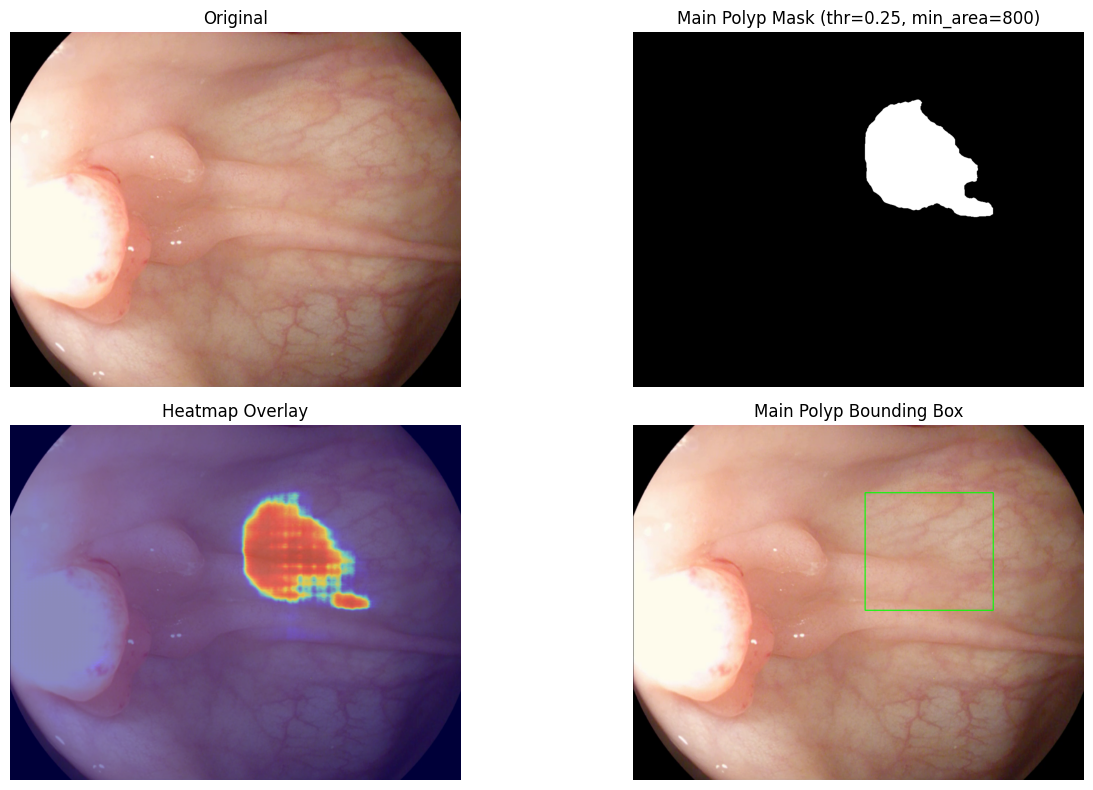

In [59]:
import glob, random
ETIS_DIR = "/content/polyp_data/unified_final/target/images"
sample = random.choice(glob.glob(ETIS_DIR+"/*"))
print("Testing:", sample)

main_mask, bbox, prob = visualize_main_polyp(
    sample,
    thr=0.25,       # key: lower threshold
    min_area=800,   # key: ignore tiny blobs
    close_ks=13,    # fill gaps in smooth large polyp
    open_ks=5       # remove speckles
)


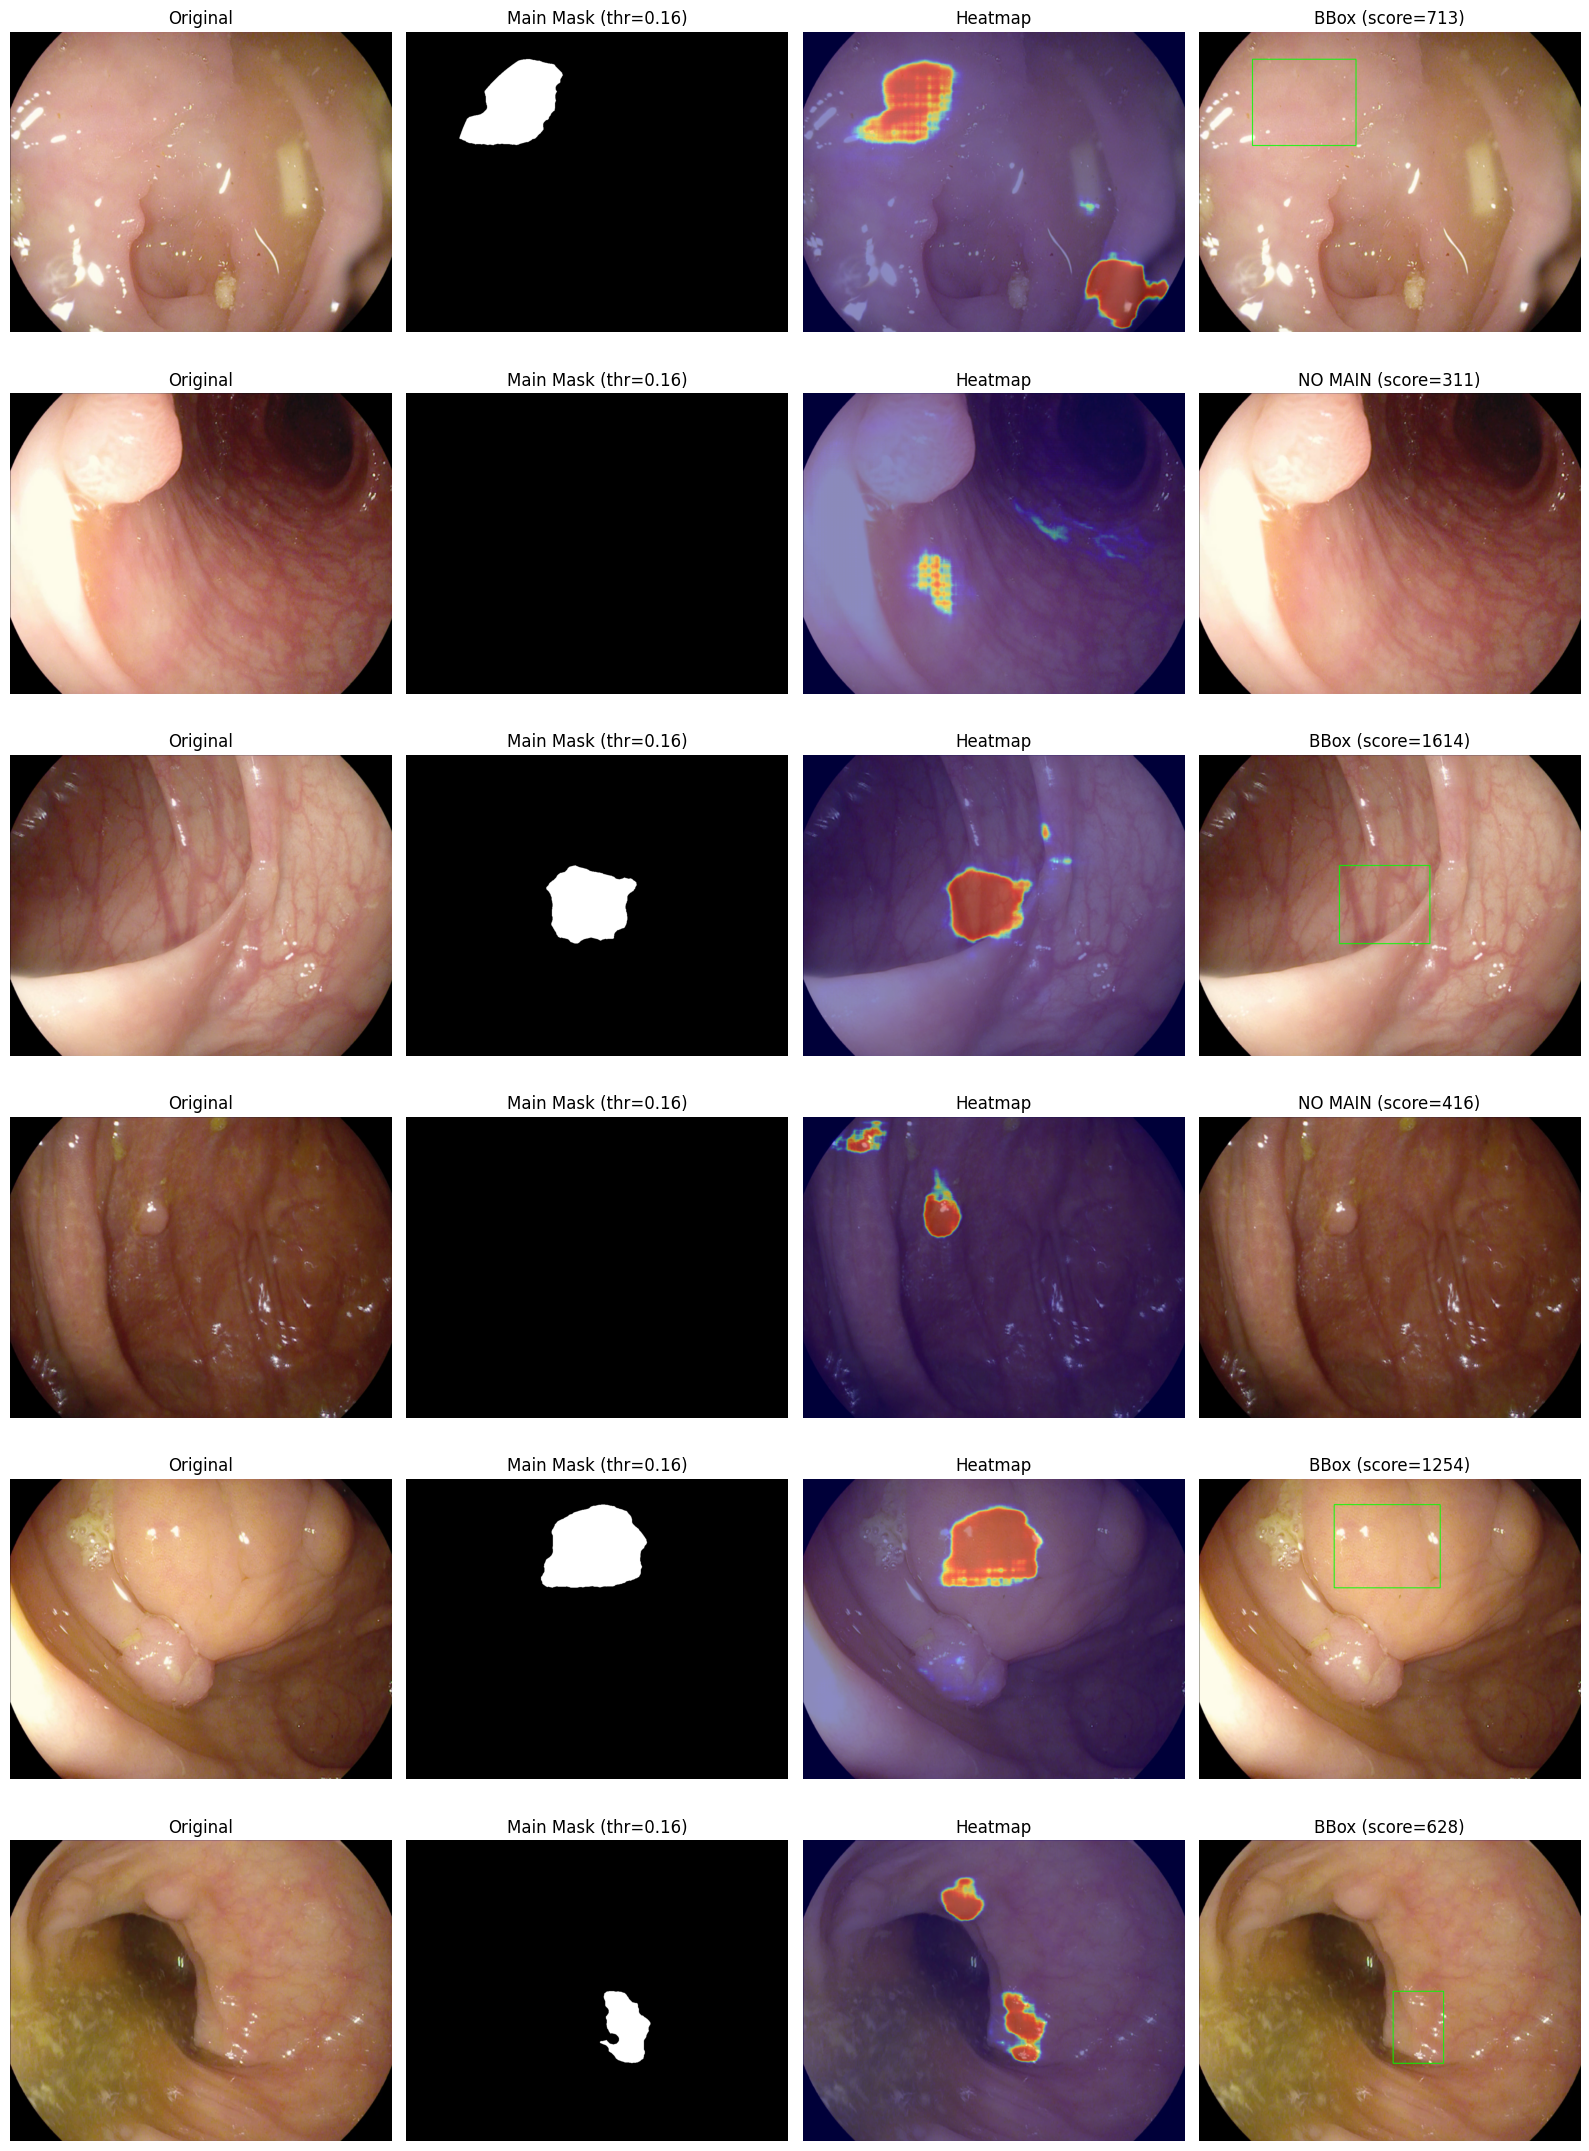

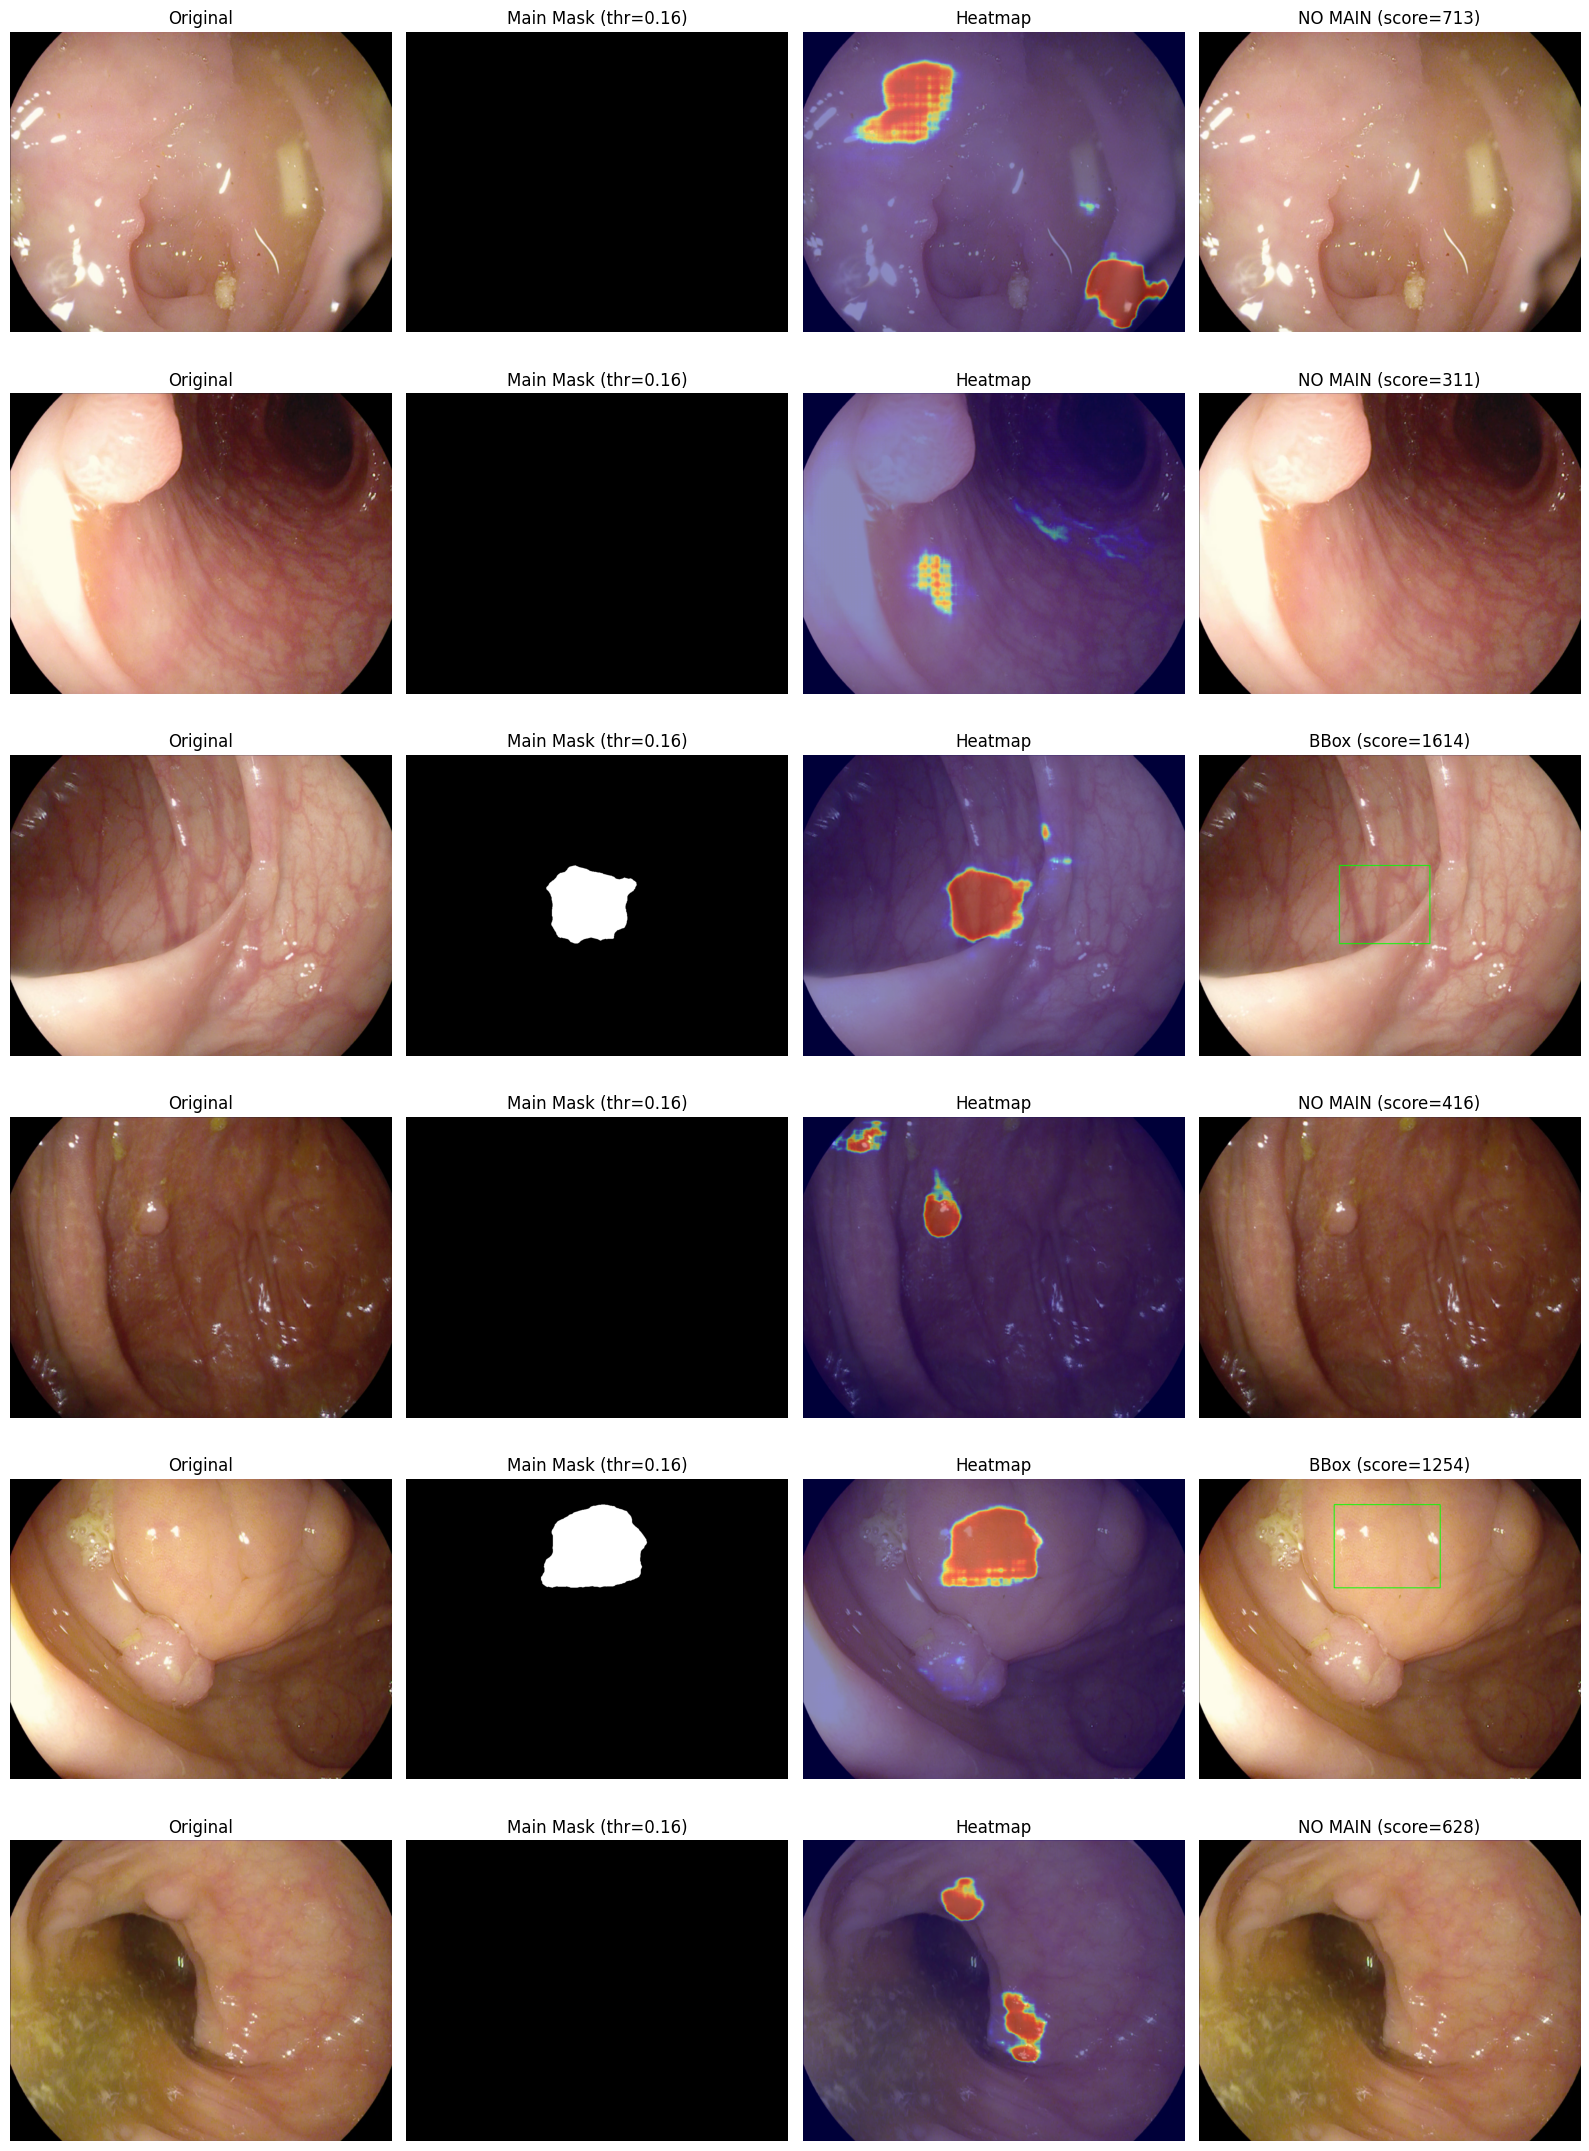

In [98]:
import os, glob, random
import cv2
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# ETIS recommended params
# -------------------------
ETIS_PARAMS = dict(
    thr=0.16,
    min_area=300,
    alpha=0.7,
    center_beta=1.2,
    border_margin=0.06,
    use_fov_mask=True,
    close_ks=17,
    open_ks=5,
)

# ✅ Two evaluation modes (NO retraining needed)
STRICT_SCORE_MIN = 1200   # for research claims (dominant polyp)
DEMO_SCORE_MIN   = 500    # for qualitative figures (higher recall)

# -------------------------
# Helpers
# -------------------------
def make_fov_mask_from_rgb_or_prob(x):
    """
    Circular endoscopy field-of-view (FOV) mask.
    Works for prob maps (H,W) or RGB images (H,W,3).
    Returns uint8 mask in {0,1}.
    """
    if x.ndim == 3:
        H, W = x.shape[:2]
    else:
        H, W = x.shape

    mask = np.zeros((H, W), dtype=np.uint8)
    radius = int(0.48 * min(H, W))
    cx, cy = W // 2, H // 2
    cv2.circle(mask, (cx, cy), radius, 1, thickness=-1)
    return mask

def preprocess_for_unet_rgb(image_path, img_size):
    """Returns: rgb_orig (H,W,3 uint8), x (1,img_size,img_size,3 float32 in [-1,1])"""
    bgr = cv2.imread(image_path)
    if bgr is None:
        raise FileNotFoundError(f"Could not read: {image_path}")
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    resized = cv2.resize(rgb, (img_size, img_size), interpolation=cv2.INTER_LINEAR)
    x = (resized.astype(np.float32) / 127.5) - 1.0
    x = np.expand_dims(x, 0)
    return rgb, x

# -------------------------
# ✅ Single definitive detector (ALWAYS returns 3 items)
# -------------------------
def detect_main_polyp_bbox_from_prob(
    prob_map,                      # (H,W) float [0,1]
    thr=0.16,
    min_area=300,
    close_ks=17,
    open_ks=5,
    alpha=0.7,
    border_margin=0.06,
    use_fov_mask=True,
    center_beta=1.2,
    score_min=STRICT_SCORE_MIN,
):
    """
    Returns: bbox, main_mask, best_score
      bbox: (x,y,w,h) or None
      main_mask: (H,W) uint8 {0,1}
      best_score: float
    """
    H, W = prob_map.shape[:2]
    pm = prob_map.copy()

    # Optional: remove outside circular endoscopy FOV
    if use_fov_mask:
        pm = pm * make_fov_mask_from_rgb_or_prob(pm)

    # Threshold
    m = (pm >= thr).astype(np.uint8)

    # Morphology cleanup
    if open_ks and open_ks > 1:
        k_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (open_ks, open_ks))
        m = cv2.morphologyEx(m, cv2.MORPH_OPEN, k_open, iterations=1)

    if close_ks and close_ks > 1:
        k_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (close_ks, close_ks))
        m = cv2.morphologyEx(m, cv2.MORPH_CLOSE, k_close, iterations=2)

    num, labels, stats, _ = cv2.connectedComponentsWithStats(m, connectivity=8)
    if num <= 1:
        return None, np.zeros_like(m), 0.0

    # Border margin in pixels
    b = int(border_margin * min(H, W))

    # Center prior
    cx0, cy0 = W / 2.0, H / 2.0
    norm = np.sqrt(cx0**2 + cy0**2) + 1e-6

    best_lab = None
    best_score = -1.0

    for lab in range(1, num):
        x = stats[lab, cv2.CC_STAT_LEFT]
        y = stats[lab, cv2.CC_STAT_TOP]
        w = stats[lab, cv2.CC_STAT_WIDTH]
        h = stats[lab, cv2.CC_STAT_HEIGHT]
        area = stats[lab, cv2.CC_STAT_AREA]

        if area < min_area:
            continue

        # Reject components too close to borders
        if (x < b) or (y < b) or (x + w > W - b) or (y + h > H - b):
            continue

        comp = (labels == lab)
        mean_conf = float(pm[comp].mean()) if np.any(comp) else 0.0

        # Center weight
        ccx = x + w / 2.0
        ccy = y + h / 2.0
        dist_center = np.sqrt((ccx - cx0)**2 + (ccy - cy0)**2) / norm
        center_weight = (1.0 - dist_center) ** center_beta

        # Current scoring scale: hundreds -> few thousands
        score = mean_conf * (area ** alpha) * center_weight

        if score > best_score:
            best_score = score
            best_lab = lab

    if best_lab is None:
        return None, np.zeros_like(m), 0.0

    main_mask = (labels == best_lab).astype(np.uint8)
    x = stats[best_lab, cv2.CC_STAT_LEFT]
    y = stats[best_lab, cv2.CC_STAT_TOP]
    w = stats[best_lab, cv2.CC_STAT_WIDTH]
    h = stats[best_lab, cv2.CC_STAT_HEIGHT]
    bbox = (x, y, w, h)

    # Gate
    if best_score < score_min:
        return None, np.zeros_like(m), float(best_score)

    return bbox, main_mask, float(best_score)

# -------------------------
# ✅ Single definitive runner (ALWAYS returns 4 items)
# -------------------------
def run_main_polyp_detection(
    image_path,
    IMG_SIZE=256,
    show=False,
    score_min=STRICT_SCORE_MIN,
    **params
):
    """
    Always returns EXACTLY 4 items:
      bbox, main_mask, prob_big, best_score
    """
    rgb, x = preprocess_for_unet_rgb(image_path, IMG_SIZE)

    prob = generator(x, training=False).numpy()[0, ..., 0]  # (256,256) in [0,1]

    H, W = rgb.shape[:2]
    prob_big = cv2.resize(prob, (W, H), interpolation=cv2.INTER_LINEAR)

    bbox, main_mask, best_score = detect_main_polyp_bbox_from_prob(
        prob_big,
        score_min=score_min,
        **params
    )

    if show:
        heat = cv2.applyColorMap((prob_big * 255).astype(np.uint8), cv2.COLORMAP_JET)
        heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)
        overlay = (0.55 * rgb + 0.45 * heat).astype(np.uint8)

        bbox_img = rgb.copy()
        if bbox is not None:
            x0, y0, w0, h0 = bbox
            cv2.rectangle(bbox_img, (x0, y0), (x0 + w0, y0 + h0), (0, 255, 0), 2)
            title_bbox = f"BBox (score={best_score:.0f})"
        else:
            title_bbox = f"NO MAIN (score={best_score:.0f} < {score_min})"

        plt.figure(figsize=(14, 8))
        plt.subplot(2,2,1); plt.title("Original"); plt.imshow(rgb); plt.axis("off")
        plt.subplot(2,2,2); plt.title(f"Main Mask (thr={params.get('thr',0.16)})"); plt.imshow(main_mask, cmap="gray"); plt.axis("off")
        plt.subplot(2,2,3); plt.title("Heatmap Overlay"); plt.imshow(overlay); plt.axis("off")
        plt.subplot(2,2,4); plt.title(title_bbox); plt.imshow(bbox_img); plt.axis("off")
        plt.tight_layout(); plt.show()

    return bbox, main_mask, prob_big, best_score

# -------------------------
# ✅ 6-image qualitative grid (clean + consistent)
# -------------------------
def show_main_polyp_results_6(
    img_dir,
    seed=42,
    IMG_SIZE=256,
    score_min=DEMO_SCORE_MIN,
    **params
):
    paths = sorted(glob.glob(os.path.join(img_dir, "*")))
    if len(paths) < 6:
        raise ValueError(f"Need at least 6 images, found {len(paths)}")

    random.seed(seed)
    samples = random.sample(paths, 6)

    fig, axes = plt.subplots(6, 4, figsize=(16, 22))

    for i, img_path in enumerate(samples):
        # ✅ ALWAYS unpack 4 values (no more unpacking errors)
        bbox, main_mask, prob, score = run_main_polyp_detection(
            img_path,
            IMG_SIZE=IMG_SIZE,
            thr=params.get("thr", 0.16),
            min_area=params.get("min_area", 300),
            alpha=params.get("alpha", 0.7),
            border_margin=params.get("border_margin", 0.06),
            center_beta=params.get("center_beta", 1.2),
            close_ks=params.get("close_ks", 17),
            open_ks=params.get("open_ks", 5),
            use_fov_mask=params.get("use_fov_mask", True),
            score_min=score_min,
            show=False,  # ✅ IMPORTANT for batch grid
        )

        bgr = cv2.imread(img_path)
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

        heat = cv2.applyColorMap((prob * 255).astype(np.uint8), cv2.COLORMAP_JET)
        heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)
        overlay = (0.55 * rgb + 0.45 * heat).astype(np.uint8)

        bbox_img = rgb.copy()
        if bbox is not None:
            x, y, w, h = bbox
            cv2.rectangle(bbox_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
            title = f"BBox (score={score:.0f})"
        else:
            title = f"NO MAIN (score={score:.0f})"

        axes[i,0].imshow(rgb);      axes[i,0].set_title("Original"); axes[i,0].axis("off")
        axes[i,1].imshow(main_mask, cmap="gray"); axes[i,1].set_title(f"Main Mask (thr={params.get('thr',0.16)})"); axes[i,1].axis("off")
        axes[i,2].imshow(overlay);  axes[i,2].set_title("Heatmap"); axes[i,2].axis("off")
        axes[i,3].imshow(bbox_img); axes[i,3].set_title(title); axes[i,3].axis("off")

    plt.tight_layout()
    plt.show()

# -------------------------
# RUN
# -------------------------
ETIS_DIR = "/content/polyp_data/unified_final/target/images"

# ✅ Demo / qualitative mode (high recall visuals)
show_main_polyp_results_6(ETIS_DIR, score_min=DEMO_SCORE_MIN, **ETIS_PARAMS)

# ✅ Strict / dominant polyp mode (for research claims)
show_main_polyp_results_6(ETIS_DIR, score_min=STRICT_SCORE_MIN, **ETIS_PARAMS)


In [100]:
import numpy as np

def _safe_div(a, b, eps=1e-7):
    return a / (b + eps)

def compute_segmentation_metrics(
    y_true,                 # (H,W) / (H,W,1) / (B,H,W,1) values in {0,1} (or 0..255 also OK)
    y_prob,                 # same shape, float in [0,1]
    thr=0.5,                # threshold for predicted mask
    conf_mode="mean_pos",   # "mean_pos" | "mean_all" | "max" | "p95_pos" | "mean_gt" | "mean_union"
    eps=1e-7
):
    """
    Pixel-level (micro-averaged) segmentation metrics.

    Returns dict with:
      Accuracy, Dice, IoU, Precision, Recall, Specificity, F1, F2,
      BalancedAcc, MCC, FPR, FNR,
      Confidence, TP, FP, TN, FN,
      PredPosRate, TruePosRate
    """

    yt = np.asarray(y_true)
    yp = np.asarray(y_prob)

    # squeeze only singleton dims (keeps batch if present)
    yt = np.squeeze(yt)
    yp = np.squeeze(yp)

    # If masks are 0..255, binarize them safely
    if yt.dtype != np.bool_:
        yt = yt.astype(np.float32)
        # if looks like 0..255 mask
        if yt.max() > 1.5:
            yt = (yt > 127.0).astype(np.uint8)
        else:
            yt = (yt >= 0.5).astype(np.uint8)
    else:
        yt = yt.astype(np.uint8)

    yp = yp.astype(np.float32)

    # Flatten all pixels (batch included if present)
    yt_f = yt.reshape(-1).astype(np.uint8)
    yp_f = yp.reshape(-1).astype(np.float32)

    # Pred binary mask
    yb = (yp_f >= thr).astype(np.uint8)

    # Confusion
    tp = int(np.sum((yb == 1) & (yt_f == 1)))
    fp = int(np.sum((yb == 1) & (yt_f == 0)))
    tn = int(np.sum((yb == 0) & (yt_f == 0)))
    fn = int(np.sum((yb == 0) & (yt_f == 1)))

    # Core metrics
    accuracy   = float(_safe_div(tp + tn, tp + tn + fp + fn, eps))
    precision  = float(_safe_div(tp, tp + fp, eps))
    recall     = float(_safe_div(tp, tp + fn, eps))  # sensitivity / TPR
    specificity= float(_safe_div(tn, tn + fp, eps))  # TNR

    dice = float(_safe_div(2 * tp, 2 * tp + fp + fn, eps))
    iou  = float(_safe_div(tp, tp + fp + fn, eps))

    f1 = float(_safe_div(2 * precision * recall, precision + recall, eps))

    beta = 2.0
    f2 = float(_safe_div((1 + beta**2) * precision * recall,
                         (beta**2) * precision + recall, eps))

    balanced_acc = float(0.5 * (recall + specificity))

    # MCC (Matthews correlation coefficient)
    denom = np.sqrt((tp+fp) * (tp+fn) * (tn+fp) * (tn+fn)) + eps
    mcc = float(((tp * tn) - (fp * fn)) / denom)

    fpr = float(_safe_div(fp, fp + tn, eps))
    fnr = float(_safe_div(fn, fn + tp, eps))

    pred_pos_rate = float(_safe_div(tp + fp, tp + fp + tn + fn, eps))
    true_pos_rate = float(_safe_div(tp + fn, tp + fp + tn + fn, eps))

    # Confidence score
    if conf_mode == "mean_pos":
        confidence = float(np.mean(yp_f[yb == 1])) if np.any(yb == 1) else 0.0
    elif conf_mode == "p95_pos":
        confidence = float(np.percentile(yp_f[yb == 1], 95)) if np.any(yb == 1) else 0.0
    elif conf_mode == "mean_all":
        confidence = float(np.mean(yp_f))
    elif conf_mode == "max":
        confidence = float(np.max(yp_f))
    elif conf_mode == "mean_gt":
        confidence = float(np.mean(yp_f[yt_f == 1])) if np.any(yt_f == 1) else 0.0
    elif conf_mode == "mean_union":
        union = (yb == 1) | (yt_f == 1)
        confidence = float(np.mean(yp_f[union])) if np.any(union) else 0.0
    else:
        raise ValueError("conf_mode must be one of: mean_pos, p95_pos, mean_all, max, mean_gt, mean_union")

    return {
        "Accuracy": accuracy,
        "Dice": dice,
        "IoU": iou,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1": f1,
        "F2": f2,
        "BalancedAcc": balanced_acc,
        "MCC": mcc,
        "FPR": fpr,
        "FNR": fnr,
        "Confidence": confidence,
        "TP": tp, "FP": fp, "TN": tn, "FN": fn,
        "PredPosRate": pred_pos_rate,
        "TruePosRate": true_pos_rate,
        "Threshold": float(thr),
        "ConfMode": str(conf_mode),
    }


In [102]:
import cv2, glob, numpy as np, random

# pick one ETIS image
ETIS_DIR = "/content/polyp_data/unified_final/target/images"
img_path = random.choice(glob.glob(ETIS_DIR + "/*"))
print("Using:", img_path)

# get prob map from your existing function (this returns prob_big in original size)
bbox, main_mask, prob_big, score = run_main_polyp_detection(
    img_path,
    IMG_SIZE=256,
    score_min=DEMO_SCORE_MIN,
    **ETIS_PARAMS
)

# y_prob exists now:
y_prob = prob_big  # (H,W) float [0,1]

# Without y_true, you can still inspect:
pred_bin = (y_prob >= 0.5).astype(np.uint8)
print("Confidence(mean_pos):", float(y_prob[pred_bin==1].mean()) if pred_bin.sum()>0 else 0.0)
print("PredPosRate:", float(pred_bin.mean()))


Using: /content/polyp_data/unified_final/target/images/etis__51.png
Confidence(mean_pos): 0.8759194016456604
PredPosRate: 0.04897198631005197


In [103]:
import numpy as np
import cv2

# Take ONE batch from val_ds
x, y = next(iter(val_ds))                  # x: images, y: GT masks (0/1)
pred = generator(x, training=False).numpy()# pred: prob (B,256,256,1)

# Pick ONE sample from the batch
i = 0
y_true = y[i].numpy()[..., 0]              # (256,256) 0/1
y_prob = pred[i][..., 0]                   # (256,256) [0,1]

# Now compute all metrics
metrics = compute_segmentation_metrics(
    y_true=y_true,
    y_prob=y_prob,
    thr=0.5,
    conf_mode="mean_pos"
)
print(metrics)


{'Accuracy': 0.9809112548813157, 'Dice': 0.029480217220366155, 'IoU': 0.014960629920081838, 'Precision': 0.27142857104081636, 'Recall': 0.015586546348188141, 'Specificity': 0.9992070525661968, 'F1': 0.029480206946771018, 'F2': 0.019207438609833094, 'BalancedAcc': 0.5073967994571925, 'MCC': 0.061190169919117555, 'FPR': 0.0007929474322484056, 'FNR': 0.9844134535697774, 'Confidence': 0.6980892419815063, 'TP': 19, 'FP': 51, 'TN': 64266, 'FN': 1200, 'PredPosRate': 0.0010681152343733702, 'TruePosRate': 0.018600463867159116, 'Threshold': 0.5, 'ConfMode': 'mean_pos'}


In [104]:
import numpy as np

all_metrics = {}

for x, y in val_ds:
    pred = generator(x, training=False).numpy()  # (B,256,256,1)

    for i in range(pred.shape[0]):
        m = compute_segmentation_metrics(
            y_true=y[i].numpy(),      # (256,256,1) ok
            y_prob=pred[i],           # (256,256,1) ok
            thr=0.5,
            conf_mode="mean_pos"
        )
        for k, v in m.items():
            if isinstance(v, (int, float)):
                all_metrics.setdefault(k, []).append(float(v))

print("\n===== VAL METRICS (mean ± std) =====")
for k in sorted(all_metrics.keys()):
    arr = np.array(all_metrics[k], dtype=np.float32)
    print(f"{k:14s}: {arr.mean():.4f} ± {arr.std():.4f}")



===== VAL METRICS (mean ± std) =====
Accuracy      : 0.9299 ± 0.0666
BalancedAcc   : 0.6756 ± 0.2108
Confidence    : 0.7612 ± 0.3347
Dice          : 0.3428 ± 0.3743
F1            : 0.3428 ± 0.3743
F2            : 0.3580 ± 0.3894
FN            : 2507.0745 ± 3257.1328
FNR           : 0.6142 ± 0.4183
FP            : 2089.2231 ± 2812.5103
FPR           : 0.0347 ± 0.0458
IoU           : 0.2804 ± 0.3283
MCC           : 0.3317 ± 0.3795
Precision     : 0.3833 ± 0.3985
PredPosRate   : 0.0753 ± 0.0729
Recall        : 0.3858 ± 0.4183
Specificity   : 0.9653 ± 0.0458
TN            : 58096.3125 ± 5737.7100
TP            : 2843.3884 ± 4199.7480
Threshold     : 0.5000 ± 0.0000
TruePosRate   : 0.0816 ± 0.0796
